# Data Analysis and Prediction

This Notebook is for analysis of the fire and AQI data extracted for Del Rio Texas and comparing certain results. The results/visualizations included are:
1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.
2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
3. Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

Also, we are deploying a Predictive Model to predict the Smoke Estimate up to 2046 in the future. I have used Time Series forecasting model here: ARIMA for the prediction.

## Import Libraries

In [2]:
import pandas as  pd
import plotly.express as px
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

## Fires Data

Import the Wildfire data we extracted for Del Rio

In [22]:
del_rio_fires_df = pd.read_csv('del_rio_fires_df.csv',index_col=False)
del_rio_fires_df.head()

/var/folders/t2/qmrm7ppx721dl9rrmn10gl7m0000gp/T/ipykernel_65086/2373649188.py:1: DtypeWarning: Columns (0,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  del_rio_fires_df = pd.read_csv('del_rio_fires_df.csv',index_col=False)


,Unnamed: 0,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,...,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_del_rio
0,0,14306,14306,Wildfire,1963.0,1,"1 (1), 3 (1)",4995.253626,2021.507422,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,"Caution, this Wildfire in 1963 overlaps with a...",0.994707,1.0,Yes,15980.673439,2.021507e+07,36.475031,-106.702400,594.570587
1,1,14305,14305,Wildfire,1963.0,1,"1 (3), 3 (3)",4995.910129,2021.773099,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,NaN,0.994948,1.0,Yes,15979.785579,2.021773e+07,35.678581,-106.479715,543.334644
2,2,14341,14341,Wildfire,1963.0,1,"1 (2), 3 (2)",647.246513,261.931371,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,NaN,0.272200,NaN,No,10996.509615,2.619314e+06,43.526843,-103.471741,986.598492
3,3,14308,14308,Wildfire,1963.0,1,"1 (1), 3 (2)",4293.410613,1737.481631,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,NaN,0.344648,NaN,No,25169.664017,1.737482e+07,43.154410,-113.233561,1171.237153
4,4,14324,14324,Wildfire,1963.0,1,"1 (1), 3 (3)",1552.699889,628.355352,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,NaN,0.709395,NaN,No,10550.269932,6.283554e+06,34.728314,-119.946244,1175.406549


In [4]:
del_rio_fires_df.describe()

,Fire_Year,GIS_Acres,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_del_rio
count,137938.000000,1.379380e+05,70856.000000,5440.0,7.085600e+04,7.085600e+04,70856.000000,70856.000000,70856.000000
mean,2008.892930,2.800136e+03,0.471232,1.0,1.188721e+04,7.238075e+06,36.498751,-102.459846,910.916485
std,11.236348,9.232289e+03,0.261129,0.0,7.500229e+04,5.111432e+07,4.669825,12.726866,273.900037
min,1963.000000,6.558795e-07,0.000051,1.0,1.212677e+00,2.654250e-03,24.671056,-121.001852,28.803066
25%,2007.000000,1.046353e+02,0.262560,1.0,1.133461e+03,5.179746e+04,33.538127,-113.798496,698.521895
50%,2013.000000,1.319904e+03,0.435546,1.0,3.932615e+03,4.773728e+05,36.015573,-105.456741,977.204411
75%,2015.000000,5.084404e+03,0.647035,1.0,1.246346e+04,4.034079e+06,39.680586,-91.351742,1148.245300
max,2020.000000,1.566273e+06,0.999917,1.0,1.757948e+07,6.338483e+09,47.462191,-80.183831,1249.996926


## Create a Smoke Estimate

We will be creating a smoke estimate based on the metrics we extracted from the fire data and create a metric which will define the impact of the fire on the city.
I have created this metric based on the proportionality of the metrics.

**Smoke Estimate:**
Smoke Estimate = (Area burned in Acres/Distance from the city)*10

Smoke estimate is directly proportional to the area burnt i.e. it will have a higher impact on the city if the area is more and is inversely proportional to the distance from the city i.e. it will have higher impact for a shorter distance from the city. 10 is used to normalize the values.

In [19]:
del_rio_fires_df['smoke_estimate'] = (del_rio_fires_df['GIS_Acres']/del_rio_fires_df['distance_from_del_rio'])*10
del_rio_fires_df.head()

,Unnamed: 0,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,...,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_del_rio,smoke_estimate
0,0,14306,14306,Wildfire,1963.0,1,"1 (1), 3 (1)",4995.253626,2021.507422,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,"Caution, this Wildfire in 1963 overlaps with a...",0.994707,1.0,Yes,15980.673439,2.021507e+07,36.475031,-106.702400,594.570587,84.014476
1,1,14305,14305,Wildfire,1963.0,1,"1 (3), 3 (3)",4995.910129,2021.773099,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,0.994948,1.0,Yes,15979.785579,2.021773e+07,35.678581,-106.479715,543.334644,91.949044
2,2,14341,14341,Wildfire,1963.0,1,"1 (2), 3 (2)",647.246513,261.931371,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,0.272200,NaN,No,10996.509615,2.619314e+06,43.526843,-103.471741,986.598492,6.560384
3,3,14308,14308,Wildfire,1963.0,1,"1 (1), 3 (2)",4293.410613,1737.481631,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,0.344648,NaN,No,25169.664017,1.737482e+07,43.154410,-113.233561,1171.237153,36.657056
4,4,14324,14324,Wildfire,1963.0,1,"1 (1), 3 (3)",1552.699889,628.355352,Comb_National_NIFC_Interagency_Fire_Perimeter_...,...,NaN,0.709395,NaN,No,10550.269932,6.283554e+06,34.728314,-119.946244,1175.406549,13.209897


The smoke estimate is then aggregated Annually where I have taken **Average/Mean** of the Daily Smoke Estimate to get an Annual Smoke Estimate. I have also tried the sum to see the variation but then finalized the Average.

In [18]:
del_rio_fires_df_annual =  del_rio_fires_df.groupby('Fire_Year').agg(sum_smoke_estimate=('smoke_estimate','sum'), avg_smoke_estimate=('smoke_estimate','mean')).reset_index()
del_rio_fires_df_annual.head()

,Fire_Year,sum_smoke_estimate,avg_smoke_estimate
0,1963.0,800.822591,3.364801
1,1964.0,2359.505274,12.418449
2,1965.0,591.580867,2.830530
3,1966.0,4312.369918,16.459427
4,1967.0,2520.693706,9.067244


#### Line Chart for sum of Smoke estimate across Years of Fire

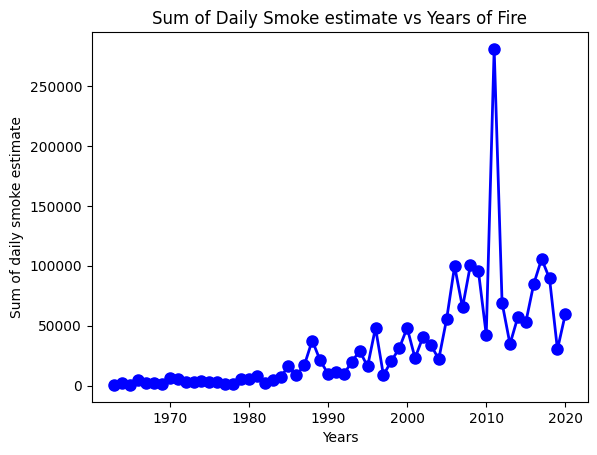

In [37]:
# plt.linechart(del_rio_fires_df_annual['Fire_Year'],del_rio_fires_df_annual['sum_smoke_estimate'])
plt.plot(del_rio_fires_df_annual['Fire_Year'],
         del_rio_fires_df_annual['sum_smoke_estimate'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Sum of Daily Smoke estimate vs Years of Fire')
plt.xlabel('Years')
plt.ylabel('Sum of daily smoke estimate')
plt.show()

#### Line Chart for Average of Smoke estimate across Years of Fire

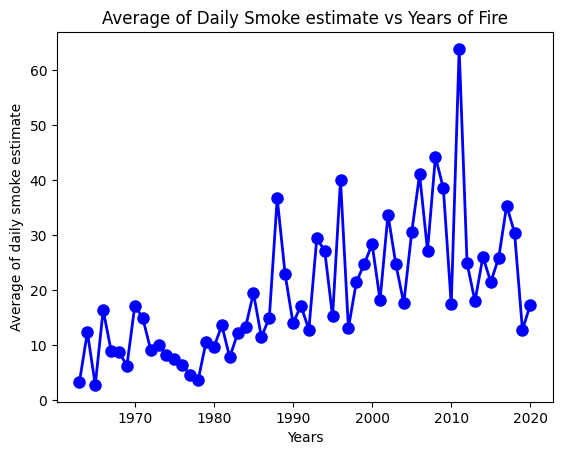

In [38]:
plt.plot(del_rio_fires_df_annual['Fire_Year'],
         del_rio_fires_df_annual['avg_smoke_estimate'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Average of Daily Smoke estimate vs Years of Fire')
plt.xlabel('Years')
plt.ylabel('Average of daily smoke estimate')
plt.show()

## AQI Data

Import AQI data extracted for Del Rio Texas

In [9]:
final_aqi_df = pd.read_csv('final_aqi.csv',index_col=False)
final_aqi_df

,Unnamed: 0,date_local,pollutant_standard,aqi
0,0,1988-03-02,NaN,20.0
1,1,1988-03-05,NaN,18.0
2,2,1988-03-09,NaN,23.0
3,3,1988-03-16,NaN,46.0
4,4,1988-03-19,NaN,11.0
...,...,...,...,...
53553,2530,2022-12-19,NaN,14.0
53554,2531,2022-12-22,NaN,20.0
53555,2532,2022-12-25,NaN,11.0
53556,2533,2022-12-28,NaN,16.0


## Annual AQI calculation

Annual AQI is calculated by taking max of AQI for each day based on Pollutant standards and then taking the Average of the top 30 AQI values for a year. This will ensure we calculate the right annual AQI

In [23]:
aqi = final_aqi_df.groupby('date_local')['aqi'].max().reset_index()
aqi['year'] = pd.to_datetime(aqi['date_local']).dt.year
aqi_per_year = aqi.groupby('year')['aqi'].apply(lambda group: group.nlargest(30).mean()).reset_index()
aqi_per_year.head()

,year,aqi
0,1988,39.300000
1,1989,42.133333
2,1990,43.333333
3,1991,38.333333
4,1992,32.966667


#### Line Chart for Annual AQI across Years of Fire for Del Rio Texas

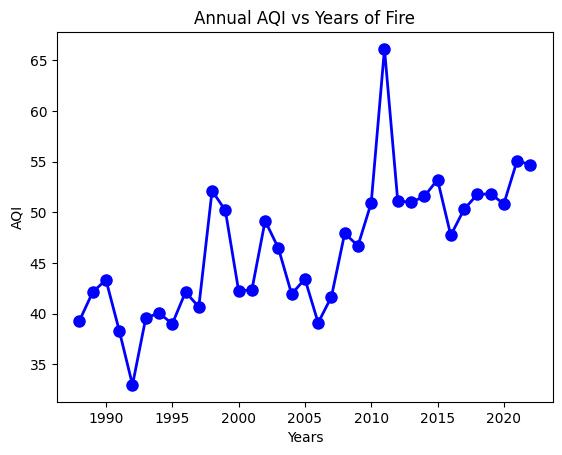

In [34]:
plt.plot(aqi_per_year['year'],
         aqi_per_year['aqi'],
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title('Annual AQI vs Years of Fire')
plt.xlabel('Years')
plt.ylabel('AQI')
plt.show()

# Visualizations

## 1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

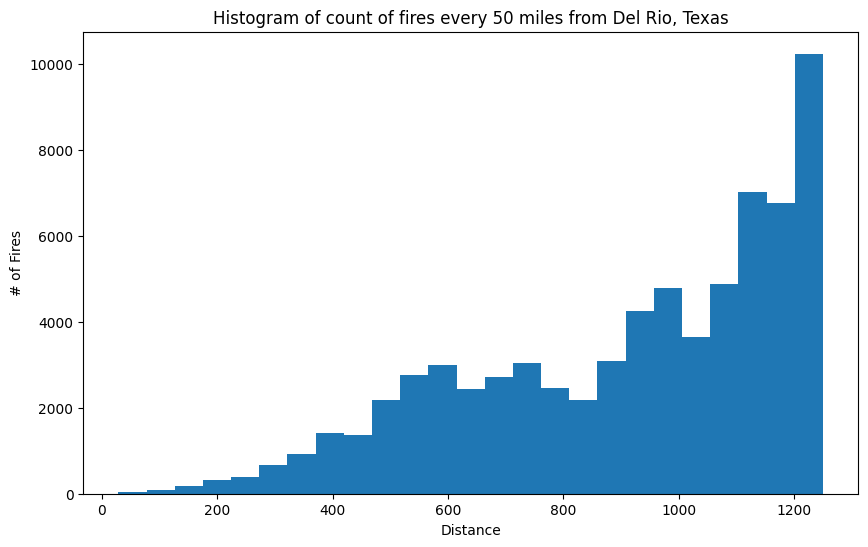

In [12]:
plt.figure(figsize=(10, 6)) 

bin_width = 50
data_range = max(del_rio_fires_df['distance_from_del_rio']) - min(del_rio_fires_df['distance_from_del_rio'])
num_bins = int(data_range / bin_width)

plt.hist(del_rio_fires_df['distance_from_del_rio'],bins=25)
# Customize the chart
plt.title('Histogram of count of fires every 50 miles from Del Rio, Texas')
plt.xlabel('Distance')
plt.ylabel('# of Fires')

# Display the chart
plt.show()

## 2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

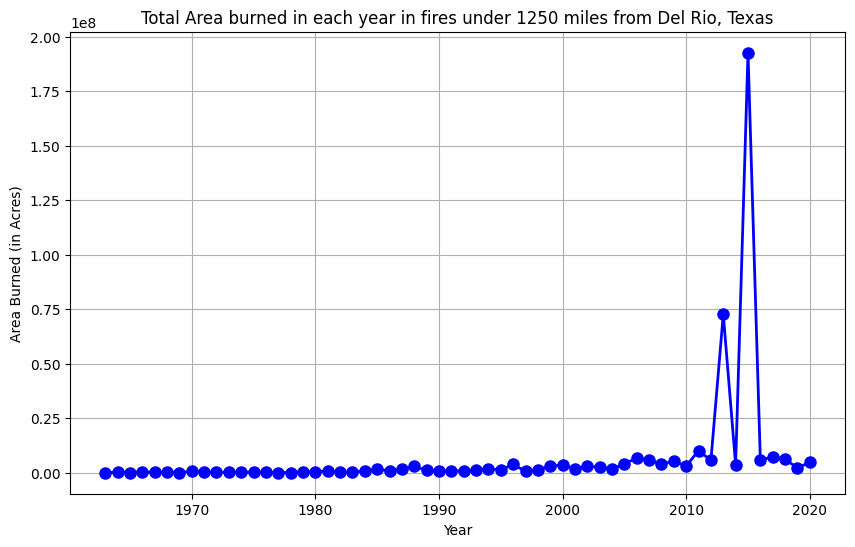

In [13]:
area_burned = del_rio_fires_df.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

plt.figure(figsize=(10, 6)) 

# Create a line chart for the second line
plt.plot(area_burned['Fire_Year'], area_burned['GIS_Acres'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Total Area burned in each year in fires under 1250 miles from Del Rio, Texas')
plt.xlabel('Year')
plt.ylabel('Area Burned (in Acres)')

# Display the chart
plt.grid(True)
plt.show()

## 3. Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

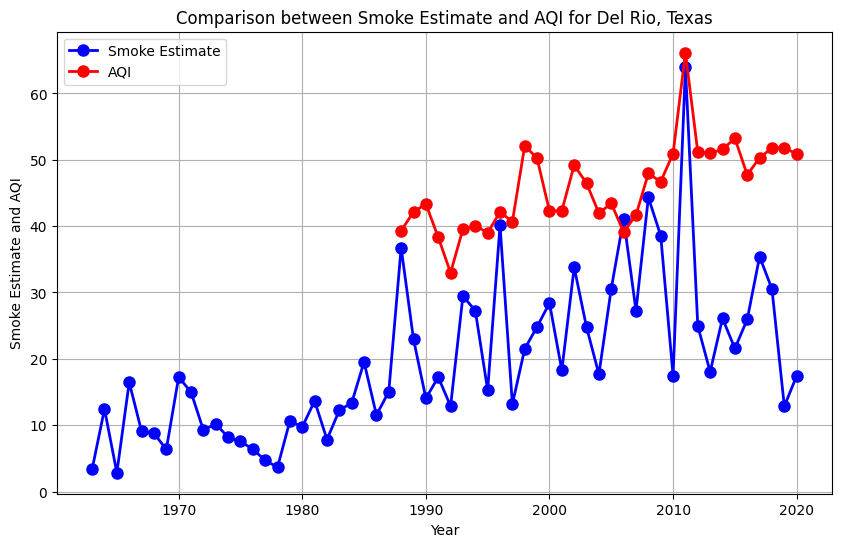

In [14]:
smoke_aqi = pd.merge(del_rio_fires_df_annual,aqi_per_year,how="left",left_on="Fire_Year",right_on="year")

plt.figure(figsize=(10, 6)) 
plt.plot(smoke_aqi['Fire_Year'], smoke_aqi['avg_smoke_estimate'], label='Smoke Estimate', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Create a line chart for the second line
plt.plot(smoke_aqi['Fire_Year'], smoke_aqi['aqi'], label='AQI', marker='o', color='r', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Comparison between Smoke Estimate and AQI for Del Rio, Texas')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate and AQI')
plt.legend()  # Add a legend to distinguish the two lines

# Display the chart
plt.grid(True)
plt.show()

# Prediction

We will be predicting the smoke estimates calculated based on current data into future uoto 2046. I am using ARIMA time series model for the prediction and displaying the final predictions using the model

## Model parameters

In [15]:
# Load your data
data = pd.Series(del_rio_fires_df_annual['avg_smoke_estimate'])  

model = pm.auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True,
                   error_action="ignore", max_order=None, trace=True, information_criterion='bic')

# Get the best order (p, d, q) determined by auto_arima
best_order = model.get_params()['order']

print("Best (p, d, q) order:", best_order)


Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=438.223, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=461.102, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=445.731, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=430.012, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=457.080, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=433.018, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=432.515, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=436.344, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=427.576, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=429.956, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=429.153, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=441.719, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=432.771, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.400 seconds
Best (p, d, q) order: (0, 1, 1)


## Fitting the model and tweaking parameters to get best  results

In [16]:
# Fit ARIMA model
model = ARIMA(data, order=(4,2,3))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=25)
predictions_data = pd.DataFrame({'Year': range(2021, 2046), 'Predictions': predictions})

print("AIC : "+str(model_fit.aic)+" BIC : "+str(model_fit.bic))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC : 428.7317236215663 BIC : 444.9345371474475


## Final Prediction Visualization

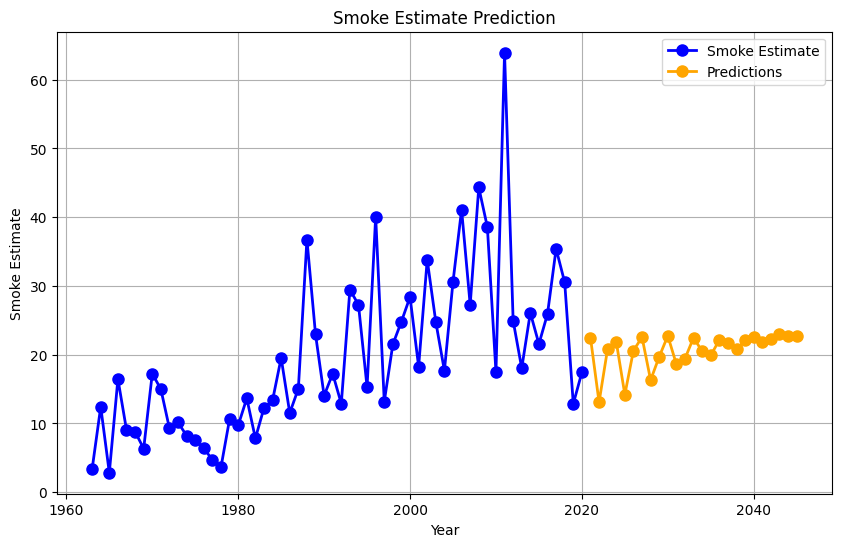

In [17]:
plt.figure(figsize=(10, 6)) 
plt.plot(del_rio_fires_df_annual['Fire_Year'], del_rio_fires_df_annual['avg_smoke_estimate'], label='Smoke Estimate', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Create a line chart for the second line
plt.plot(predictions_data['Year'], predictions_data['Predictions'], label='Predictions', marker='o', color='orange', linestyle='-', linewidth=2, markersize=8)

# Customize the chart
plt.title('Smoke Estimate Prediction')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()  # Add a legend to distinguish the two lines

# Display the chart
plt.grid(True)
plt.show()